In [57]:
from PIL import Image
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay
import pickle
import random
#l load block design
System = Overlay("./LeNet-5/LeNet-5.bit")
np.set_printoptions(threshold=np.inf)
xlink = Xlnk()

cnn = System.LeNet_Hw_1
#cnn = System.LeNet_Hw_0

# load trained weights and bias data 
# conv layer1
conv1_w_d = np.array(np.load('./LeNet-5/weight/conv1_weight.npy'))
conv1_w_n = conv1_w_d
conv1_w_d = conv1_w_d.flatten()
conv1_b_d = np.array(np.load('./LeNet-5/weight/conv1_bias.npy'))
# convlayer 2
conv2_w_d = np.array(np.load('./LeNet-5/weight/conv2_weight.npy'))
conv2_w_d = conv2_w_d.flatten()
conv2_b_d = np.array(np.load('./LeNet-5/weight/conv2_bias.npy'))
# fc layer 1
fc1_w_d = np.array(np.load('./LeNet-5/weight/fc1_weight.npy'))
fc1_w_d = fc1_w_d.flatten()
fc1_b_d = np.array(np.load('./LeNet-5/weight/fc1_bias.npy'))
# fc layer 2
fc2_w_d = np.array(np.load('./LeNet-5/weight/fc2_weight.npy'))
fc2_w_d = fc2_w_d.flatten()
fc2_b_d = np.array(np.load('./LeNet-5/weight/fc2_bias.npy'))


# allocate cma storage for weights and bias
conv1_w = xlink.cma_array(dtype=np.float32, shape=conv1_w_d.shape)
conv1_b = xlink.cma_array(dtype=np.float32, shape=conv1_b_d.shape)
conv2_w = xlink.cma_array(dtype=np.float32, shape=conv2_w_d.shape)
conv2_b = xlink.cma_array(dtype=np.float32, shape=conv2_b_d.shape)
fc1_w = xlink.cma_array(dtype=np.float32, shape=fc1_w_d.shape)
fc1_b = xlink.cma_array(dtype=np.float32, shape=fc1_b_d.shape)
fc2_w = xlink.cma_array(dtype=np.float32, shape=fc2_w_d.shape)
fc2_b = xlink.cma_array(dtype=np.float32, shape=fc2_b_d.shape)


# value the cma_arrays
for i in range(0, len(conv1_w)):
    conv1_w[i] = conv1_w_d[i]
    
for i in range(0, len(conv2_w)):
    conv2_w[i] = conv2_w_d[i]
    
for i in range(0,  len(fc1_w)):
    fc1_w[i] = fc1_w_d[i]

for i in range(0, len(fc2_w)):
    fc2_w[i] = fc2_w_d[i] 

for i in range(0, len(conv1_b)):
    conv1_b[i] = conv1_b_d[i]
    
for i in range(0, len(conv2_b)):
    conv2_b[i] = conv2_b_d[i]
    
for i in range(0, len(fc1_b)):
    fc1_b[i] = fc1_b_d[i]

for i in range(0, len(fc2_b)):
    fc2_b[i] = fc2_b_d[i]

In [43]:
# write the weight to cma
cnn.write(0x10, conv1_w.physical_address)
cnn.write(0x18, conv1_b.physical_address)
cnn.write(0x20, conv2_w.physical_address)
cnn.write(0x28, conv2_b.physical_address)
cnn.write(0x30, fc1_w.physical_address)
cnn.write(0x38, fc1_b.physical_address)
cnn.write(0x40, fc2_w.physical_address)
cnn.write(0x48, fc2_b.physical_address)
#training_file = './dataset/train.p'
# testing_file = './dataset/test.p'
validation_file = './dataset/valid.p'
# with open(training_file, mode='rb') as f:
#     train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
# with open(testing_file, mode='rb') as f:
#     test = pickle.load(f)

# get and handle x and labels, train, verify, test
# X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
# X_test, y_test = test['features'], test['labels']


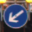

In [44]:

# convert image to float32
# X_train = X_train / 255.
pic = random.randint(0, 4409)
image = Image.fromarray(X_valid[pic], 'RGB') 
display(image)
input_data_x = X_valid[pic].flatten()/255.
# X_test = X_test / 255.

In [45]:
input_data = xlink.cma_array(shape=input_data_x.shape,dtype=np.float32)
for i in range(0, 32*32*3):
    input_data[i] = input_data_x[i]
output_data = [0]

In [46]:
output_data = xlink.cma_array(shape=(43,), dtype=np.float32)

In [47]:
cnn.write(0x50, input_data.physical_address)
cnn.write(0x58, output_data.physical_address)

In [48]:
cnn.write(0x00,0x01)

In [50]:
cnn.read(0x00)

4

In [53]:
print(output_data2)

[-99.07108307 -44.2970314  -30.69173431 -55.25376129 -47.97771454
 -46.38699341 -82.82016754 -58.73001862 -47.35760117 -41.52633667
 -33.31685257 -25.37948227 -24.10945702  -4.63276863 -59.23654175
 -37.35062408 -95.33548737 -43.35505676 -22.65315247 -54.54660034
 -46.7528038  -42.84762192 -67.39425659 -49.40078735 -50.36933136
 -25.57388306 -16.4247303  -70.77894592 -38.86230469 -63.6580658
 -20.20014572 -69.77253723 -66.64678192 -44.37129211 -49.94668198
 -35.64908981 -53.31739044 -69.40719604 -29.44225693 -46.24604797
 -38.37256241 -74.50823212 -87.87885284]


In [23]:
print(output_data[y_valid[pic]])

-13.205


In [24]:
print(input_data_x.shape)

(3072,)


In [12]:
conv1_w_d = conv1_w_d.flatten()


In [30]:
print(y_valid[50])

31


In [56]:
print(cnn.read(0x10))
print(cnn.read(0x18))
print(cnn.read(0x20))
print(cnn.read(0x28))
print(cnn.read(0x30))
print(cnn.read(0x38))
print(cnn.read(0x40))
print(cnn.read(0x48))

403030016
402964480
403439616
402952192
403701760
402956288
403046400
402960384


In [35]:
output_data2 = xlink.cma_array(shape=(43,), dtype=np.float32)

In [20]:
print(fc2_b_d)

[-0.7015496  -0.19099085  0.23535542  0.26620874  0.61630106  0.07375957
  0.25447664  0.11241125  0.24587978  0.17414868 -0.0722549  -0.3514663
 -0.02427191  0.2707248  -0.23876141 -0.16607036 -0.41281974 -0.37386805
  0.795826   -0.09183946  0.26129675 -0.16890979 -0.12226483 -0.21312277
 -0.07244485 -0.24176474 -0.29838565 -0.12231627 -0.10786093 -0.5388251
  0.10671729  0.44438684  0.24628383 -0.05444041 -0.27453715 -0.26280457
 -0.01166748 -0.6224933  -0.04978522 -0.31594244 -0.4801519  -0.5099658
 -0.16409658]


In [61]:
print(fc2_b)

[-0.70154959 -0.19099085  0.23535542  0.26620874  0.61630106  0.07375957
  0.25447664  0.11241125  0.24587978  0.17414868 -0.0722549  -0.3514663
 -0.02427191  0.2707248  -0.23876141 -0.16607036 -0.41281974 -0.37386805
  0.79582602 -0.09183946  0.26129675 -0.16890979 -0.12226483 -0.21312277
 -0.07244485 -0.24176474 -0.29838565 -0.12231627 -0.10786093 -0.53882509
  0.10671729  0.44438684  0.24628383 -0.05444041 -0.27453715 -0.26280457
 -0.01166748 -0.62249333 -0.04978522 -0.31594244 -0.48015189 -0.50996578
 -0.16409658]


In [59]:
print(conv1_w)

[  8.70804638e-02  -1.28990620e-01  -9.51469690e-02  -1.12421043e-01
  -2.00584725e-01  -4.39862497e-02   1.32389799e-01   3.14766467e-02
   5.84422015e-02  -3.05433899e-01  -5.02434559e-02  -8.51273090e-02
   2.75072246e-03  -5.94569035e-02  -8.37493539e-02  -7.31794164e-02
   2.41485499e-02   6.32079318e-02  -1.99571587e-02  -2.36350179e-01
  -3.72294784e-02  -1.66398272e-01   2.00174451e-01  -2.83701152e-01
  -2.60690749e-01  -4.01931256e-01   3.14211011e-01  -7.10348114e-02
  -1.90472379e-02   3.06612194e-01   9.35895890e-02  -1.42989710e-01
   1.85511485e-01  -9.66705456e-02  -1.77948058e-01  -1.66740850e-01
  -2.03954548e-01   2.47354925e-01  -2.31702626e-01   5.47154360e-02
  -1.75757632e-01  -9.97907296e-02   1.85295884e-02  -1.23902254e-01
  -3.89922224e-02  -3.05220671e-02   3.96758579e-02   4.94083911e-02
  -1.08805671e-01   5.00645451e-02   4.07152670e-03  -1.64561257e-01
   6.97073713e-02  -2.40780577e-01   1.45805135e-01  -2.49052301e-01
  -7.26635039e-01  -3.69554669e-01